In [1]:
import import_ipynb
from FunctionsList import *

import pandas as pd
import numpy as np
import seaborn as sns
import random
import gensim
import joblib 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm, preprocessing
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


from keras import regularizers, callbacks
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense

importing Jupyter notebook from FunctionsList.ipynb


In [2]:
#import data:
data = pd.read_csv('Data/CleanDataset.csv')
data.head()

,Unnamed: 0,label,review_content
0,0,2,telefon solid complex telefon trebui user medi...
1,1,0,samsung sfe aproxim zil trecut diferent sist a...
2,2,2,livr inceat zil vizav telefon multum greu foli...
3,3,0,pacat display sparg mic ating inlocu cost apro...
4,4,1,misc bin ok costat stel deoarec nu instal prog...


In [3]:
data.isna().any().tolist()

[False, False, False]

### Impartirea setului de date

In [4]:
# imparte setul de date: 80% - 20% 
contents = data['review_content']
labels = data['label']
x_train, x_test, y_train, y_test = train_test_split(contents, labels, train_size=0.8, random_state=42)

In [5]:
x_train.head()

15669    misc ok mid rang poz bin facut singur problem ...
6778     achizition telefon magazin acum lun pret excel...
8638     ajuns reped cred telefon mar ae frumos poz nu ...
13834    raspund reped display bun aud bin bater tin su...
12126                bater praf nu sta intr duc mar defect
Name: review_content, dtype: object

In [6]:
y_train

15669    1
6778     2
8638     1
13834    0
12126    0
        ..
13418    2
5390     2
860      0
15795    1
7270     1
Name: label, Length: 12900, dtype: int64

### Vectorizare TF-IDF 

In [7]:
#tfidf lucreaza cu secventele intregi - pt a nu mai detokeniza si tokeniza inca o data
#am definit functia mytokenizer care va fi inclusa ca parametru in tfidfvectorizer

vectorizer = TfidfVectorizer(min_df=2, lowercase=False)

x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

In [8]:
print("x_train.shape:", x_train.shape)# 12900 samples 8120 features
print("x_test.shape :", x_test.shape)

x_train.shape: (12900, 8142)
x_test.shape : (3225, 8142)


In [9]:
print("y_train.shape:", y_train.shape)
print("y_test.shape :", y_test.shape)

y_train.shape: (12900,)
y_test.shape : (3225,)


In [10]:
y_test

4291     2
1358     2
11513    2
5981     0
5323     2
        ..
2525     2
11402    2
14342    2
14065    1
15975    1
Name: label, Length: 3225, dtype: int64

In [11]:
print(vectorizer.vocabulary_)

{'misc': 4526, 'ok': 5042, 'mid': 4468, 'rang': 5920, 'poz': 5582, 'bin': 814, 'facut': 2611, 'singur': 6694, 'problem': 5726, 'intaln': 3740, 'pan': 5195, 'acum': 96, 'cablu': 1014, 'type': 7569, 'mearg': 4375, 'conect': 1497, 'telefon': 7276, 'android': 359, 'auto': 622, 'cabl': 1012, 'original': 5134, 'nu': 4948, 'function': 2946, 'achizition': 59, 'magazin': 4256, 'lun': 4235, 'pret': 5658, 'excelent': 2503, 'ofer': 5028, 'preciz': 5611, 'detin': 2000, 'iphon': 3878, 'bat': 735, 'bun': 979, 'mod': 4555, 'portret': 5555, 'blureaz': 874, 'pro': 5717, 'super': 7101, 'noapt': 4897, 'video': 7860, 'acept': 41, 'filmeaz': 2726, 'blocheaz': 856, 'crush': 1685, 'aplicat': 442, 'putut': 5871, 'instal': 3720, 'aplic': 440, 'rapid': 5922, 'inclus': 3523, 'servic': 6577, 'banking': 717, 'neobt': 4795, 'brd': 922, 'vazut': 7791, 'loc': 4160, 'gmail': 3102, 'vin': 7875, 'mail': 4265, 'preinstal': 5631, 'putet': 5867, 'log': 4174, 'bater': 744, 'incarc': 3481, 'reped': 6124, 'ora': 5110, 'zil': 8

In [12]:
max_features = len(vectorizer.vocabulary_)
max_features

8142

## Crearea si antrenarea de modele de clasificare

### Random forest

In [13]:
# definirea modelului
rf = RandomForestClassifier() 
rf_model = rf.fit(x_train, y_train)

In [14]:
pred = rf_model.predict(x_test)

In [15]:
confusion_matrix(y_test, pred)

array([[763, 133, 193],
       [209, 592, 280],
       [ 81,  51, 923]], dtype=int64)

In [16]:
accuracy_score(y_test, pred)

0.7063565891472868

In [21]:
#grid search pentru parametrii cei mai buni
param_grid = { 
    'n_estimators': [100, 300, 500, 700, 800],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10, 20, 30, 40, 50],
    'criterion' :['gini', 'entropy'],
    'bootstrap' :[True, False]
}

cv = GridSearchCV(rf, param_grid = param_grid, cv=3, n_jobs=-1, verbose=1) #n_jobs=> foloseste toate core-urile pentru rapiditate

search_results = cv.fit(x_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [22]:
#adauga toate rezultatele intr-un dataframe
# afiseaza primele 5 rezultate dupa acuratete

res = pd.concat([pd.DataFrame(search_results.cv_results_["params"]),
                 pd.DataFrame(search_results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
res.sort_values(by=['Accuracy'], ascending=False).head(5)

,bootstrap,criterion,max_depth,max_features,n_estimators,Accuracy
149,False,gini,50,sqrt,800,0.715581
146,False,gini,50,sqrt,300,0.715349
144,False,gini,50,auto,800,0.715116
139,False,gini,40,sqrt,800,0.714884
148,False,gini,50,sqrt,700,0.714806


In [23]:
search_results.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'n_estimators': 800}

In [17]:
# definirea modelului
bestRF = RandomForestClassifier(n_estimators=800, 
                                criterion='gini', 
                                max_depth=50, 
                                max_features='sqrt',
                                bootstrap=False)
                                   
bestRF_model = bestRF.fit(x_train, y_train)

In [18]:
pred = bestRF_model.predict(x_test)

In [19]:
accuracy_score(y_test, pred)

0.7172093023255814

In [20]:
print(classification_report(pred, y_test, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.70      0.75      0.72      1013
           n       0.56      0.79      0.65       761
         pos       0.91      0.66      0.76      1451

    accuracy                           0.72      3225
   macro avg       0.72      0.73      0.71      3225
weighted avg       0.76      0.72      0.72      3225



Text(0.5, 1.0, 'Confusion Matrix')

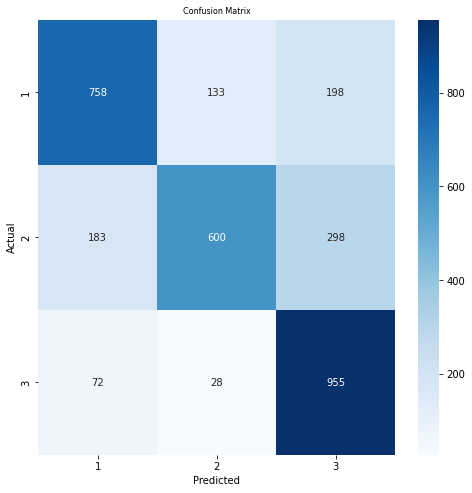

In [21]:
confusion_mat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[1,2,3], 
            yticklabels=[1,2,3])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix", size=8)

In [22]:
joblib.dump(bestRF_model, "Models/tfidf_rf_model.joblib")

['Models/tfidf_rf_model.joblib']

### SVM

In [13]:
# definirea modelului
clf = SVC()
svm_model = clf.fit(x_train, y_train)

In [14]:
pred = clf.predict(x_test)
accuracy_score(pred, y_test)

0.7311627906976744

In [20]:
svm_model.get_params()
joblib.dump(svm_model, "Models/tfidf_svm_model.joblib")

['Models/tfidf_svm_model.joblib']

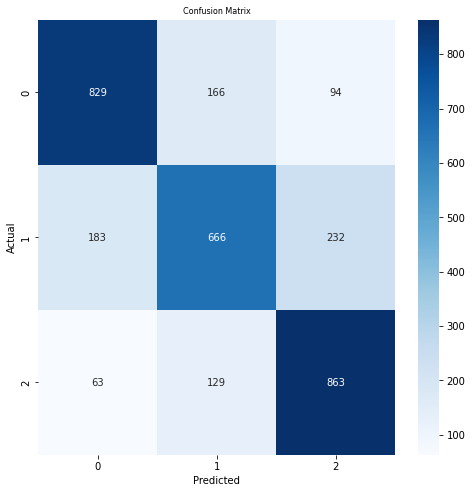

In [21]:
confusion_mat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[0,1,2], 
            yticklabels=[0,1,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix", size=8);

In [22]:
print(classification_report(pred, y_test, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.76      0.77      0.77      1075
           n       0.62      0.69      0.65       961
         pos       0.82      0.73      0.77      1189

    accuracy                           0.73      3225
   macro avg       0.73      0.73      0.73      3225
weighted avg       0.74      0.73      0.73      3225



In [31]:
#grid search parametrii cei mai buni
param_grid = {'C': [1, 10, 100], #penalizare
              'gamma': [0.1, 0.01, 0.001], #kernel coef - in ce masura influenteaza calculul liniei plauzibile de separare
              'kernel': ['rbf', 'poly']}

grid = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2)
svm_search_results = grid.fit(x_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [32]:
#adauga toate rezultatele intr-un dataframe
# afiseaza primele 5 rezultate dupa acuratete

svm_res = pd.concat([pd.DataFrame(svm_search_results.cv_results_["params"]),
                 pd.DataFrame(svm_search_results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
svm_res.sort_values(by=['Accuracy'], ascending=False).head(5)

,C,gamma,kernel,Accuracy
8,10,0.010,rbf,0.712713
16,100,0.001,rbf,0.712558
0,1,0.100,rbf,0.711550
6,10,0.100,rbf,0.702171
14,100,0.010,rbf,0.693101


In [33]:
svm_search_results.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [26]:
# definirea modelului cel mai bun
clf = SVC(C=10, 
          gamma= 0.01, 
          kernel='rbf', 
          probability=True)
svm_model = clf.fit(x_train, y_train)

In [27]:
pred = svm_model.predict(x_test)
accuracy_score(pred, y_test)

0.7190697674418605

Text(0.5, 1.0, 'Confusion Matrix')

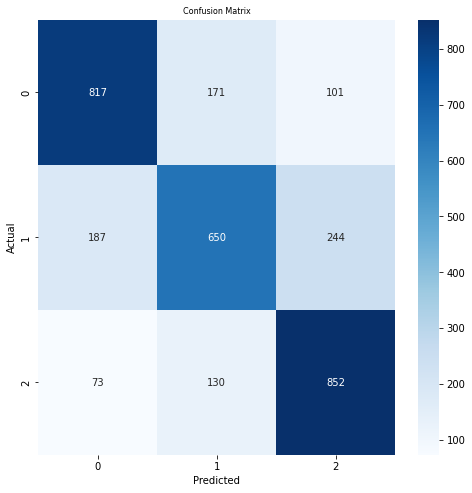

In [29]:
confusion_mat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[0,1,2], 
            yticklabels=[0,1,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix", size=8)

In [31]:
print(classification_report(pred, y_test, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.75      0.76      0.75      1077
           n       0.60      0.68      0.64       951
         pos       0.81      0.71      0.76      1197

    accuracy                           0.72      3225
   macro avg       0.72      0.72      0.72      3225
weighted avg       0.73      0.72      0.72      3225



### Bernouli NB

In [13]:
from sklearn.naive_bayes import BernoulliNB

In [30]:
clf = BernoulliNB()
bnb_model = clf.fit(x_train, y_train)

In [31]:
pred = clf.predict(x_test)
accuracy_score(pred, y_test)

0.6142635658914729

Text(0.5, 1.0, 'Confusion Matrix')

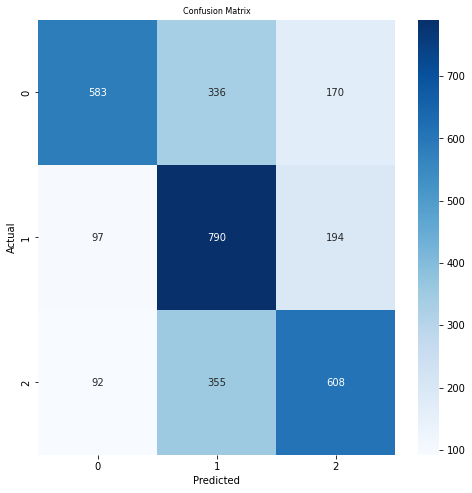

In [32]:
confusion_mat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[0,1,2], 
            yticklabels=[0,1,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix", size=8)

In [33]:
print(classification_report(pred, y_test, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.54      0.76      0.63       772
           n       0.73      0.53      0.62      1481
         pos       0.58      0.63      0.60       972

    accuracy                           0.61      3225
   macro avg       0.61      0.64      0.61      3225
weighted avg       0.64      0.61      0.61      3225



In [22]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

grid = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2)
bnb_search_results = grid.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [36]:
clf = BernoulliNB()

param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
              'binarize': [0.0, 0.1, 0.2, 0.5, 0.7, 1.0]}

grid = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=1)
bnb_search_results = grid.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [37]:
#adauga toate rezultatele intr-un dataframe
# afiseaza primele 5 rezultate dupa acuratete

bnb_res = pd.concat([pd.DataFrame(bnb_search_results.cv_results_["params"]),
                 pd.DataFrame(bnb_search_results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
bnb_res.sort_values(by=['Accuracy'], ascending=False).head(5)

,alpha,binarize,Accuracy
13,0.50,0.1,0.673411
7,0.10,0.1,0.672171
19,1.00,0.1,0.670465
1,0.01,0.1,0.662791
20,1.00,0.2,0.616279


In [38]:
clf = BernoulliNB(binarize=0.1,alpha=0.5)
bnb_best_model = clf.fit(x_train,y_train)

In [39]:
pred = clf.predict(x_test)
accuracy_score(pred, y_test)

0.684031007751938

Text(0.5, 1.0, 'Confusion Matrix')

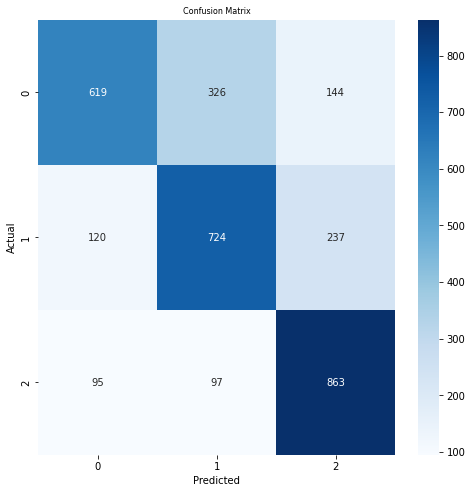

In [40]:
confusion_mat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[0,1,2], 
            yticklabels=[0,1,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix", size=8)

In [41]:
print(classification_report(pred, y_test, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.57      0.74      0.64       834
           n       0.67      0.63      0.65      1147
         pos       0.82      0.69      0.75      1244

    accuracy                           0.68      3225
   macro avg       0.69      0.69      0.68      3225
weighted avg       0.70      0.68      0.69      3225



In [42]:
joblib.dump(bnb_best_model, "Models/tfidf_bnb_model.joblib")

['Models/tfidf_bnb_model.joblib']

### Densely Connected Model

In [13]:
#one-hot encode labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
print("y_train.shape:", y_train.shape)
print("y_test.shape :", y_test.shape)

y_train.shape: (12900, 3)
y_test.shape : (3225, 3)


In [14]:
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
============================= Folosind un singur strat + output =================

In [15]:
# creaza modelul-----------512---------------
base_model = Sequential()
base_model.add(Dense(512, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 13s 37ms/step - loss: 0.7323 - acc: 0.6992 - val_loss: 0.6511 - val_acc: 0.7230
Epoch 2/10
343/343 [==============================] - 13s 37ms/step - loss: 0.5139 - acc: 0.7896 - val_loss: 0.6655 - val_acc: 0.7090
Epoch 3/10
343/343 [==============================] - 13s 37ms/step - loss: 0.4274 - acc: 0.8303 - val_loss: 0.6975 - val_acc: 0.7142
Epoch 4/10
343/343 [==============================] - 13s 38ms/step - loss: 0.3604 - acc: 0.8626 - val_loss: 0.7459 - val_acc: 0.7049
Epoch 5/10
343/343 [==============================] - 13s 37ms/step - loss: 0.3076 - acc: 0.8837 - val_loss: 0.8063 - val_acc: 0.6972
Epoch 6/10
343/343 [==============================] - 13s 38ms/step - loss: 0.2625 - acc: 0.9050 - val_loss: 0.8796 - val_acc: 0.6956
Epoch 7/10
343/343 [==============================] - 13s 38ms/step - loss: 0.2220 - acc: 0.9216 - val_loss: 0.9645 - val_acc: 0.6920
Epoch 8/10
343/343 [==============================] - 13s 37ms

In [26]:
base_model.optimizer.get_config()

{'name': 'RMSprop',
 'learning_rate': 0.001,
 'decay': 0.0,
 'rho': 0.9,
 'momentum': 0.0,
 'epsilon': 1e-07,
 'centered': False}

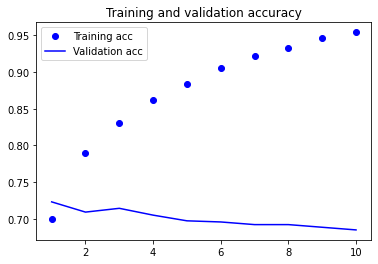

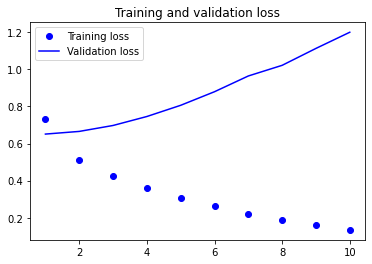

In [16]:
plot_graphs(history)

In [18]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 1s 4ms/step - loss: 1.1645 - acc: 0.6909


[1.1644909381866455, 0.690852701663971]

In [19]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.73      0.71      0.72      1122
           n       0.59      0.63      0.61      1000
         pos       0.75      0.72      0.74      1103

    accuracy                           0.69      3225
   macro avg       0.69      0.69      0.69      3225
weighted avg       0.69      0.69      0.69      3225



In [30]:
# creaza modelul---------------256--------------
base_model = Sequential()
base_model.add(Dense(256, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 7s 18ms/step - loss: 0.7578 - acc: 0.6852 - val_loss: 0.6570 - val_acc: 0.7245
Epoch 2/10
343/343 [==============================] - 6s 17ms/step - loss: 0.5352 - acc: 0.7818 - val_loss: 0.6548 - val_acc: 0.7189
Epoch 3/10
343/343 [==============================] - 6s 18ms/step - loss: 0.4541 - acc: 0.8182 - val_loss: 0.6861 - val_acc: 0.7121
Epoch 4/10
343/343 [==============================] - 6s 17ms/step - loss: 0.3995 - acc: 0.8444 - val_loss: 0.7186 - val_acc: 0.7075
Epoch 5/10
343/343 [==============================] - 6s 17ms/step - loss: 0.3527 - acc: 0.8632 - val_loss: 0.7737 - val_acc: 0.6961
Epoch 6/10
343/343 [==============================] - 6s 18ms/step - loss: 0.3142 - acc: 0.8820 - val_loss: 0.8082 - val_acc: 0.7003
Epoch 7/10
343/343 [==============================] - 6s 18ms/step - loss: 0.2816 - acc: 0.8947 - val_loss: 0.8539 - val_acc: 0.6992
Epoch 8/10
343/343 [==============================] - 6s 17ms/step - 

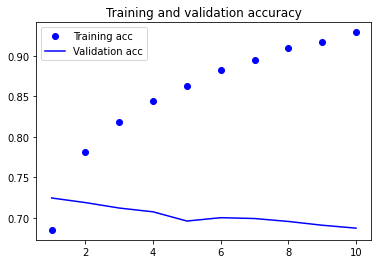

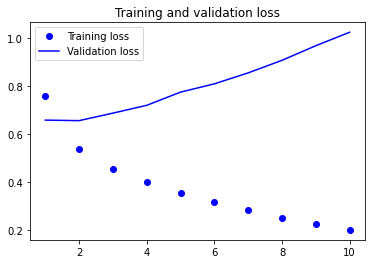

In [31]:
plot_graphs(history)

In [32]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 0s 2ms/step - loss: 0.9842 - acc: 0.6998


[0.9842157959938049, 0.6998449563980103]

In [33]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.70      0.74      0.72      1029
           n       0.61      0.64      0.62      1030
         pos       0.79      0.72      0.75      1166

    accuracy                           0.70      3225
   macro avg       0.70      0.70      0.70      3225
weighted avg       0.70      0.70      0.70      3225



In [35]:
# creaza modelul---------------128---------------
base_model = Sequential()
base_model.add(Dense(128, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 4s 11ms/step - loss: 0.8001 - acc: 0.6881 - val_loss: 0.6741 - val_acc: 0.7225
Epoch 2/10
343/343 [==============================] - 4s 10ms/step - loss: 0.5620 - acc: 0.7715 - val_loss: 0.6555 - val_acc: 0.7127
Epoch 3/10
343/343 [==============================] - 3s 10ms/step - loss: 0.4850 - acc: 0.8076 - val_loss: 0.6685 - val_acc: 0.7178
Epoch 4/10
343/343 [==============================] - 3s 10ms/step - loss: 0.4325 - acc: 0.8274 - val_loss: 0.7132 - val_acc: 0.7116
Epoch 5/10
343/343 [==============================] - 3s 10ms/step - loss: 0.3934 - acc: 0.8452 - val_loss: 0.7173 - val_acc: 0.7101
Epoch 6/10
343/343 [==============================] - 3s 9ms/step - loss: 0.3594 - acc: 0.8631 - val_loss: 0.7459 - val_acc: 0.7018
Epoch 7/10
343/343 [==============================] - 3s 9ms/step - loss: 0.3302 - acc: 0.8753 - val_loss: 0.7793 - val_acc: 0.6992
Epoch 8/10
343/343 [==============================] - 3s 9ms/step - los

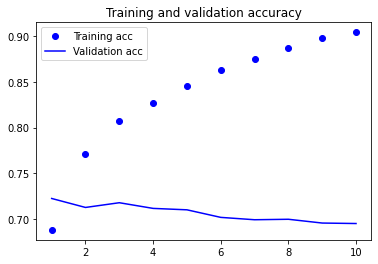

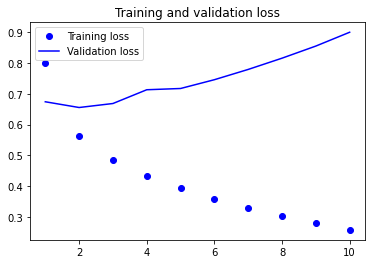

In [36]:
plot_graphs(history)

In [37]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 0s 2ms/step - loss: 0.8615 - acc: 0.7095


[0.861508309841156, 0.7094573378562927]

In [38]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.72      0.74      0.73      1060
           n       0.61      0.66      0.63      1000
         pos       0.80      0.72      0.76      1165

    accuracy                           0.71      3225
   macro avg       0.71      0.71      0.71      3225
weighted avg       0.71      0.71      0.71      3225



In [39]:
# creaza modelul--------------64--------------
base_model = Sequential()
base_model.add(Dense(64, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 3s 6ms/step - loss: 0.8513 - acc: 0.6681 - val_loss: 0.7056 - val_acc: 0.7152
Epoch 2/10
343/343 [==============================] - 2s 7ms/step - loss: 0.5964 - acc: 0.7614 - val_loss: 0.6610 - val_acc: 0.7225
Epoch 3/10
343/343 [==============================] - 2s 7ms/step - loss: 0.5158 - acc: 0.7932 - val_loss: 0.6612 - val_acc: 0.7096
Epoch 4/10
343/343 [==============================] - 2s 7ms/step - loss: 0.4664 - acc: 0.8144 - val_loss: 0.6728 - val_acc: 0.7127
Epoch 5/10
343/343 [==============================] - 2s 6ms/step - loss: 0.4288 - acc: 0.8299 - val_loss: 0.6956 - val_acc: 0.7101
Epoch 6/10
343/343 [==============================] - 2s 6ms/step - loss: 0.3974 - acc: 0.8442 - val_loss: 0.7200 - val_acc: 0.7039
Epoch 7/10
343/343 [==============================] - 2s 7ms/step - loss: 0.3716 - acc: 0.8605 - val_loss: 0.7433 - val_acc: 0.7028
Epoch 8/10
343/343 [==============================] - 2s 7ms/step - loss: 0.

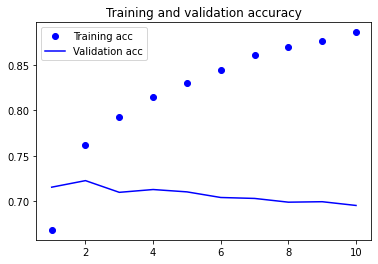

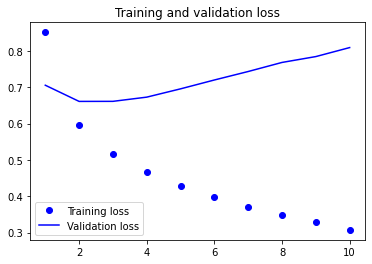

In [40]:
plot_graphs(history)

In [41]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 0s 1ms/step - loss: 0.7954 - acc: 0.7060


[0.7954440712928772, 0.7060465216636658]

In [42]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.76      0.72      0.74      1145
           n       0.60      0.65      0.63      1002
         pos       0.76      0.74      0.75      1078

    accuracy                           0.71      3225
   macro avg       0.71      0.70      0.70      3225
weighted avg       0.71      0.71      0.71      3225



In [112]:
# creaza modelul-------------------32--------------
base_model = Sequential()
base_model.add(Dense(32, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 16s 36ms/step - loss: 0.8929 - acc: 0.6666 - val_loss: 0.7482 - val_acc: 0.7034
Epoch 2/10
343/343 [==============================] - 12s 34ms/step - loss: 0.6377 - acc: 0.7502 - val_loss: 0.6814 - val_acc: 0.7209
Epoch 3/10
343/343 [==============================] - 12s 36ms/step - loss: 0.5507 - acc: 0.7791 - val_loss: 0.6612 - val_acc: 0.7116
Epoch 4/10
343/343 [==============================] - 12s 35ms/step - loss: 0.5010 - acc: 0.8022 - val_loss: 0.6639 - val_acc: 0.7101
Epoch 5/10
343/343 [==============================] - 11s 32ms/step - loss: 0.4638 - acc: 0.8207 - val_loss: 0.6744 - val_acc: 0.7075
Epoch 6/10
343/343 [==============================] - 12s 34ms/step - loss: 0.4344 - acc: 0.8309 - val_loss: 0.6892 - val_acc: 0.7080
Epoch 7/10
343/343 [==============================] - 12s 34ms/step - loss: 0.4093 - acc: 0.8398 - val_loss: 0.7032 - val_acc: 0.7116
Epoch 8/10
343/343 [==============================] - 12s 35ms

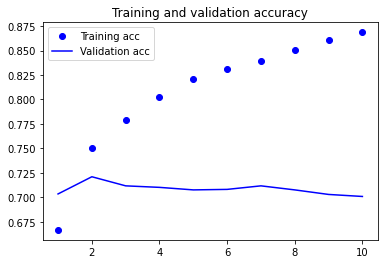

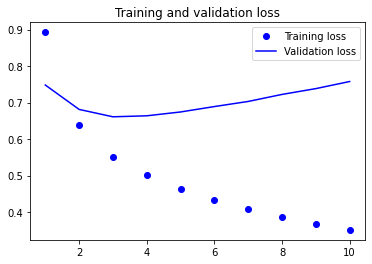

In [113]:
plot_graphs(history)

In [114]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 12s 1ms/step - loss: 0.7368 - acc: 0.7212


[0.7368239760398865, 0.7212402820587158]

In [115]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.77      0.74      0.76      1128
           n       0.60      0.68      0.64       958
         pos       0.79      0.73      0.76      1139

    accuracy                           0.72      3225
   macro avg       0.72      0.72      0.72      3225
weighted avg       0.73      0.72      0.72      3225



In [108]:
# creaza modelul-------------------16--------------
base_model = Sequential()
base_model.add(Dense(64, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 17s 41ms/step - loss: 0.8380 - acc: 0.6800 - val_loss: 0.6953 - val_acc: 0.7189
Epoch 2/10
343/343 [==============================] - 14s 40ms/step - loss: 0.5924 - acc: 0.7622 - val_loss: 0.6542 - val_acc: 0.7214
Epoch 3/10
343/343 [==============================] - 13s 38ms/step - loss: 0.5143 - acc: 0.7945 - val_loss: 0.6618 - val_acc: 0.7163
Epoch 4/10
343/343 [==============================] - 13s 39ms/step - loss: 0.4648 - acc: 0.8158 - val_loss: 0.6728 - val_acc: 0.7147
Epoch 5/10
343/343 [==============================] - 14s 39ms/step - loss: 0.4272 - acc: 0.8335 - val_loss: 0.6915 - val_acc: 0.7127
Epoch 6/10
343/343 [==============================] - 13s 38ms/step - loss: 0.3953 - acc: 0.8485 - val_loss: 0.7096 - val_acc: 0.7116
Epoch 7/10
343/343 [==============================] - 13s 38ms/step - loss: 0.3682 - acc: 0.8608 - val_loss: 0.7386 - val_acc: 0.7111
Epoch 8/10
343/343 [==============================] - 13s 38ms

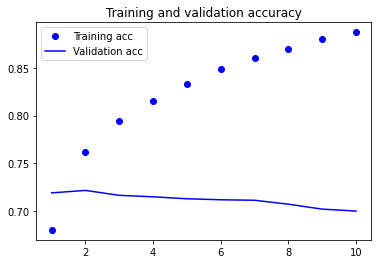

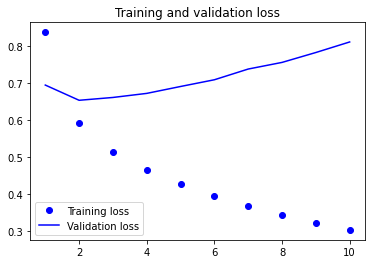

In [109]:
plot_graphs(history)

In [110]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 11s 1ms/step - loss: 0.7930 - acc: 0.7098


[0.7930408120155334, 0.7097674608230591]

In [111]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.72      0.75      0.73      1050
           n       0.63      0.65      0.64      1050
         pos       0.78      0.73      0.76      1125

    accuracy                           0.71      3225
   macro avg       0.71      0.71      0.71      3225
weighted avg       0.71      0.71      0.71      3225



In [104]:
# creaza modelul------------------------8--------------
base_model = Sequential()
base_model.add(Dense(8, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 16s 36ms/step - loss: 0.9916 - acc: 0.5696 - val_loss: 0.8925 - val_acc: 0.6010
Epoch 2/10
343/343 [==============================] - 12s 36ms/step - loss: 0.8057 - acc: 0.6565 - val_loss: 0.7847 - val_acc: 0.6744
Epoch 3/10
343/343 [==============================] - 12s 36ms/step - loss: 0.7056 - acc: 0.7202 - val_loss: 0.7312 - val_acc: 0.7023
Epoch 4/10
343/343 [==============================] - 13s 37ms/step - loss: 0.6414 - acc: 0.7548 - val_loss: 0.7014 - val_acc: 0.7116
Epoch 5/10
343/343 [==============================] - 13s 39ms/step - loss: 0.5939 - acc: 0.7694 - val_loss: 0.6871 - val_acc: 0.7111
Epoch 6/10
343/343 [==============================] - 12s 36ms/step - loss: 0.5584 - acc: 0.7823 - val_loss: 0.6814 - val_acc: 0.7090
Epoch 7/10
343/343 [==============================] - 12s 36ms/step - loss: 0.5307 - acc: 0.7912 - val_loss: 0.6838 - val_acc: 0.7090
Epoch 8/10
343/343 [==============================] - 12s 36ms

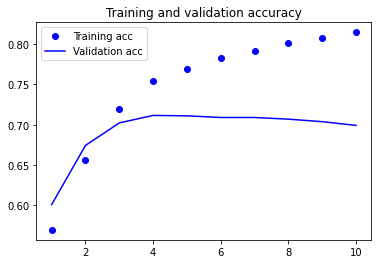

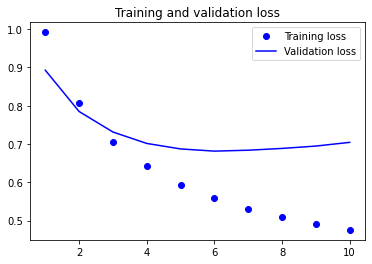

In [105]:
plot_graphs(history)

In [106]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 12s 1ms/step - loss: 0.6897 - acc: 0.7172


[0.6897046566009521, 0.7172092795372009]

In [107]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.76      0.76      0.76      1090
           n       0.62      0.65      0.63      1020
         pos       0.78      0.73      0.75      1115

    accuracy                           0.72      3225
   macro avg       0.72      0.72      0.72      3225
weighted avg       0.72      0.72      0.72      3225



In [ ]:
==================== experimente cu doua straturi dense + output =======================================================

In [28]:
# creaza modelul--------32---32----
model = Sequential()
model.add(Dense(32, input_shape =(max_features,) , activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

# compile and fit
model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 1s 2ms/step - loss: 0.8396 - acc: 0.6685 - val_loss: 0.6811 - val_acc: 0.7209
Epoch 2/10
343/343 [==============================] - 1s 2ms/step - loss: 0.5638 - acc: 0.7707 - val_loss: 0.6998 - val_acc: 0.7137
Epoch 3/10
343/343 [==============================] - 1s 2ms/step - loss: 0.4793 - acc: 0.8075 - val_loss: 0.6808 - val_acc: 0.7111
Epoch 4/10
343/343 [==============================] - 1s 2ms/step - loss: 0.4192 - acc: 0.8343 - val_loss: 0.7122 - val_acc: 0.7111
Epoch 5/10
343/343 [==============================] - 1s 2ms/step - loss: 0.3714 - acc: 0.8605 - val_loss: 0.7540 - val_acc: 0.6992
Epoch 6/10
343/343 [==============================] - 1s 2ms/step - loss: 0.3298 - acc: 0.8769 - val_loss: 0.8013 - val_acc: 0.6987
Epoch 7/10
343/343 [==============================] - 1s 2ms/step - loss: 0.2952 - acc: 0.8914 - val_loss: 0.8546 - val_acc: 0.6899
Epoch 8/10
343/343 [==============================] - 1s 2ms/step - loss: 0.

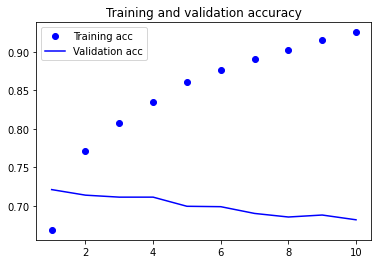

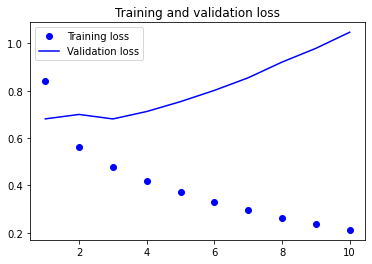

In [29]:
plot_graphs(history)

In [30]:
model.evaluate(x_test,y_test)

101/101 [==============================] - 0s 685us/step - loss: 1.0083 - acc: 0.6989


[1.0083087682724, 0.6989147067070007]

In [31]:
pred=model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.74      0.72      0.73      1125
           n       0.58      0.66      0.61       954
         pos       0.78      0.72      0.75      1146

    accuracy                           0.70      3225
   macro avg       0.70      0.70      0.70      3225
weighted avg       0.71      0.70      0.70      3225



In [32]:
# creaza modelul--------32---8----
model = Sequential()
model.add(Dense(32, input_shape =(max_features,) , activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

# compile and fit
model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 1s 2ms/step - loss: 0.7994 - acc: 0.6839 - val_loss: 0.6725 - val_acc: 0.7163
Epoch 2/10
343/343 [==============================] - 1s 2ms/step - loss: 0.5567 - acc: 0.7732 - val_loss: 0.6631 - val_acc: 0.7199
Epoch 3/10
343/343 [==============================] - 1s 2ms/step - loss: 0.4784 - acc: 0.8094 - val_loss: 0.6845 - val_acc: 0.7132
Epoch 4/10
343/343 [==============================] - 1s 2ms/step - loss: 0.4221 - acc: 0.8359 - val_loss: 0.7373 - val_acc: 0.7106
Epoch 5/10
343/343 [==============================] - 1s 2ms/step - loss: 0.3782 - acc: 0.8552 - val_loss: 0.7620 - val_acc: 0.7034
Epoch 6/10
343/343 [==============================] - 1s 2ms/step - loss: 0.3398 - acc: 0.8722 - val_loss: 0.8056 - val_acc: 0.6977
Epoch 7/10
343/343 [==============================] - 1s 2ms/step - loss: 0.3058 - acc: 0.8847 - val_loss: 0.8328 - val_acc: 0.6951
Epoch 8/10
343/343 [==============================] - 1s 2ms/step - loss: 0.

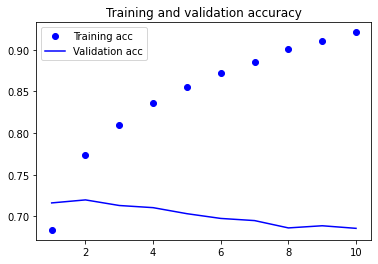

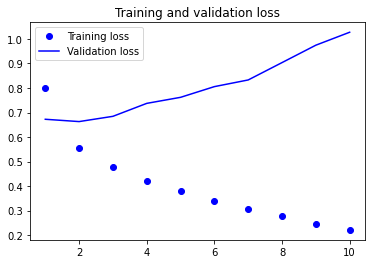

In [33]:
plot_graphs(history)

In [34]:
model.evaluate(x_test, y_test)

101/101 [==============================] - 0s 709us/step - loss: 0.9863 - acc: 0.6949


[0.9862771034240723, 0.6948837041854858]

In [35]:
pred=model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.72      0.72      0.72      1096
           n       0.60      0.64      0.62      1013
         pos       0.76      0.72      0.74      1116

    accuracy                           0.69      3225
   macro avg       0.70      0.69      0.69      3225
weighted avg       0.70      0.69      0.70      3225



In [ ]:
===================================  ADAM  ==========================================

In [75]:
# creaza modelul----------------512---------------
base_model = Sequential()
base_model.add(Dense(512, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 20s 49ms/step - loss: 1.0304 - acc: 0.6028 - val_loss: 0.9348 - val_acc: 0.6966
Epoch 2/10
343/343 [==============================] - 16s 48ms/step - loss: 0.8114 - acc: 0.7363 - val_loss: 0.7705 - val_acc: 0.7147
Epoch 3/10
343/343 [==============================] - 17s 48ms/step - loss: 0.6566 - acc: 0.7676 - val_loss: 0.7062 - val_acc: 0.7116
Epoch 4/10
343/343 [==============================] - 17s 49ms/step - loss: 0.5696 - acc: 0.7938 - val_loss: 0.6812 - val_acc: 0.7121
Epoch 5/10
343/343 [==============================] - 16s 48ms/step - loss: 0.5116 - acc: 0.8182 - val_loss: 0.6746 - val_acc: 0.7075
Epoch 6/10
343/343 [==============================] - 17s 48ms/step - loss: 0.4661 - acc: 0.8346 - val_loss: 0.6757 - val_acc: 0.7075
Epoch 7/10
343/343 [==============================] - 16s 47ms/step - loss: 0.4285 - acc: 0.8506 - val_loss: 0.6827 - val_acc: 0.7080
Epoch 8/10
343/343 [==============================] - 17s 50ms

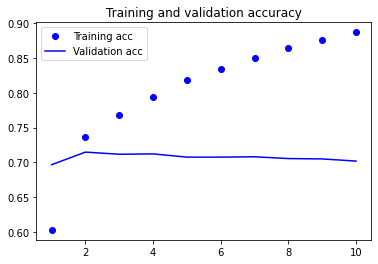

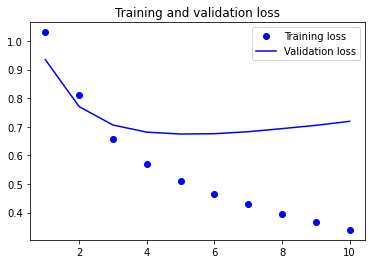

In [76]:
plot_graphs(history)

In [77]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 11s 4ms/step - loss: 0.7054 - acc: 0.7060


[0.7053894400596619, 0.7060465216636658]

In [78]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.76      0.73      0.75      1126
           n       0.59      0.65      0.62       985
         pos       0.77      0.73      0.75      1114

    accuracy                           0.71      3225
   macro avg       0.71      0.70      0.70      3225
weighted avg       0.71      0.71      0.71      3225



In [79]:
# creaza modelul----------------256---------------
base_model = Sequential()
base_model.add(Dense(256, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 17s 41ms/step - loss: 1.0536 - acc: 0.5003 - val_loss: 0.9888 - val_acc: 0.6806
Epoch 2/10
343/343 [==============================] - 13s 39ms/step - loss: 0.8923 - acc: 0.7139 - val_loss: 0.8422 - val_acc: 0.7090
Epoch 3/10
343/343 [==============================] - 13s 38ms/step - loss: 0.7432 - acc: 0.7539 - val_loss: 0.7557 - val_acc: 0.7127
Epoch 4/10
343/343 [==============================] - 14s 41ms/step - loss: 0.6466 - acc: 0.7771 - val_loss: 0.7138 - val_acc: 0.7121
Epoch 5/10
343/343 [==============================] - 14s 42ms/step - loss: 0.5826 - acc: 0.7963 - val_loss: 0.6915 - val_acc: 0.7065
Epoch 6/10
343/343 [==============================] - 14s 41ms/step - loss: 0.5350 - acc: 0.8118 - val_loss: 0.6811 - val_acc: 0.7049
Epoch 7/10
343/343 [==============================] - 15s 43ms/step - loss: 0.4973 - acc: 0.8272 - val_loss: 0.6782 - val_acc: 0.7039
Epoch 8/10
343/343 [==============================] - 14s 41ms

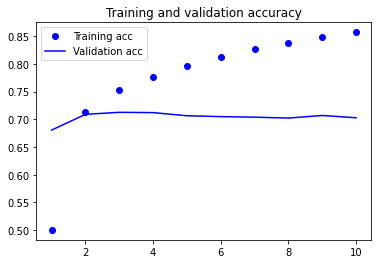

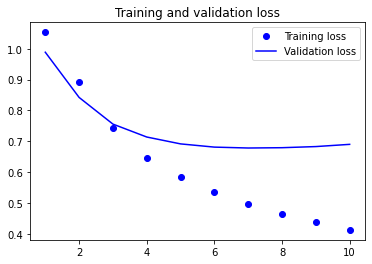

In [81]:
plot_graphs(history)

In [82]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 12s 2ms/step - loss: 0.6734 - acc: 0.7141


[0.6734118461608887, 0.7141085267066956]

In [83]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.75      0.75      0.75      1085
           n       0.63      0.65      0.64      1052
         pos       0.76      0.74      0.75      1088

    accuracy                           0.71      3225
   macro avg       0.71      0.71      0.71      3225
weighted avg       0.72      0.71      0.71      3225



In [84]:
# creaza modelul-------------128---------------
base_model = Sequential()
base_model.add(Dense(128, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 17s 40ms/step - loss: 1.0664 - acc: 0.5894 - val_loss: 1.0202 - val_acc: 0.6532
Epoch 2/10
343/343 [==============================] - 12s 36ms/step - loss: 0.9474 - acc: 0.7102 - val_loss: 0.9022 - val_acc: 0.6982
Epoch 3/10
343/343 [==============================] - 13s 38ms/step - loss: 0.8201 - acc: 0.7442 - val_loss: 0.8127 - val_acc: 0.7070
Epoch 4/10
343/343 [==============================] - 13s 39ms/step - loss: 0.7233 - acc: 0.7658 - val_loss: 0.7567 - val_acc: 0.7080
Epoch 5/10
343/343 [==============================] - 13s 37ms/step - loss: 0.6539 - acc: 0.7793 - val_loss: 0.7222 - val_acc: 0.7070
Epoch 6/10
343/343 [==============================] - 12s 36ms/step - loss: 0.6020 - acc: 0.7936 - val_loss: 0.7008 - val_acc: 0.7080
Epoch 7/10
343/343 [==============================] - 12s 35ms/step - loss: 0.5616 - acc: 0.8058 - val_loss: 0.6893 - val_acc: 0.7054
Epoch 8/10
343/343 [==============================] - 14s 40ms

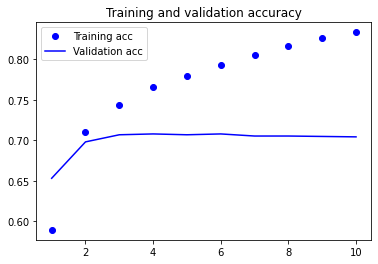

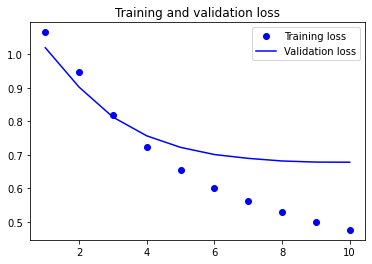

In [85]:
plot_graphs(history)

In [86]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 11s 2ms/step - loss: 0.6613 - acc: 0.7181


[0.6613287925720215, 0.7181395292282104]

In [87]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.75      0.75      0.75      1090
           n       0.61      0.67      0.64       983
         pos       0.79      0.73      0.76      1152

    accuracy                           0.72      3225
   macro avg       0.72      0.72      0.72      3225
weighted avg       0.72      0.72      0.72      3225



In [88]:
# creaza modelul--------------64---------------
base_model = Sequential()
base_model.add(Dense(64, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 16s 38ms/step - loss: 1.0755 - acc: 0.4956 - val_loss: 1.0434 - val_acc: 0.6243
Epoch 2/10
343/343 [==============================] - 12s 36ms/step - loss: 0.9922 - acc: 0.6748 - val_loss: 0.9594 - val_acc: 0.6786
Epoch 3/10
343/343 [==============================] - 12s 36ms/step - loss: 0.8962 - acc: 0.7288 - val_loss: 0.8827 - val_acc: 0.6961
Epoch 4/10
343/343 [==============================] - 13s 37ms/step - loss: 0.8104 - acc: 0.7486 - val_loss: 0.8209 - val_acc: 0.7147
Epoch 5/10
343/343 [==============================] - 12s 36ms/step - loss: 0.7402 - acc: 0.7655 - val_loss: 0.7759 - val_acc: 0.7163
Epoch 6/10
343/343 [==============================] - 13s 37ms/step - loss: 0.6847 - acc: 0.7747 - val_loss: 0.7439 - val_acc: 0.7142
Epoch 7/10
343/343 [==============================] - 12s 35ms/step - loss: 0.6406 - acc: 0.7839 - val_loss: 0.7224 - val_acc: 0.7137
Epoch 8/10
343/343 [==============================] - 12s 34ms

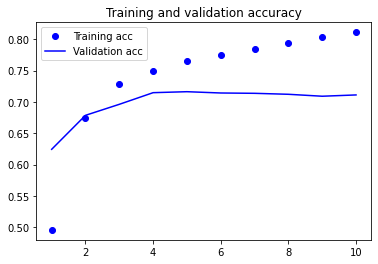

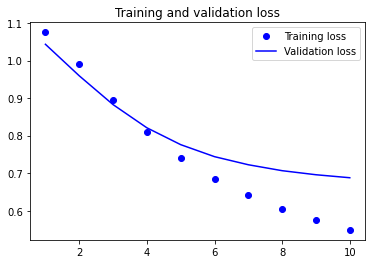

In [89]:
plot_graphs(history)

In [90]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 11s 1ms/step - loss: 0.6716 - acc: 0.7178


[0.6715583205223083, 0.7178294658660889]

In [91]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.77      0.74      0.75      1132
           n       0.58      0.70      0.63       899
         pos       0.81      0.71      0.76      1194

    accuracy                           0.72      3225
   macro avg       0.72      0.72      0.71      3225
weighted avg       0.73      0.72      0.72      3225



In [92]:
# creaza modelul-------------------32---------------
base_model = Sequential()
base_model.add(Dense(32, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 16s 36ms/step - loss: 1.0806 - acc: 0.4240 - val_loss: 1.0586 - val_acc: 0.5287
Epoch 2/10
343/343 [==============================] - 12s 35ms/step - loss: 1.0245 - acc: 0.6163 - val_loss: 1.0035 - val_acc: 0.6522
Epoch 3/10
343/343 [==============================] - 12s 35ms/step - loss: 0.9594 - acc: 0.6900 - val_loss: 0.9478 - val_acc: 0.6961
Epoch 4/10
343/343 [==============================] - 12s 35ms/step - loss: 0.8950 - acc: 0.7319 - val_loss: 0.8963 - val_acc: 0.7028
Epoch 5/10
343/343 [==============================] - 12s 34ms/step - loss: 0.8350 - acc: 0.7466 - val_loss: 0.8511 - val_acc: 0.7080
Epoch 6/10
343/343 [==============================] - 12s 35ms/step - loss: 0.7818 - acc: 0.7589 - val_loss: 0.8139 - val_acc: 0.7142
Epoch 7/10
343/343 [==============================] - 12s 35ms/step - loss: 0.7358 - acc: 0.7690 - val_loss: 0.7833 - val_acc: 0.7127
Epoch 8/10
343/343 [==============================] - 12s 35ms

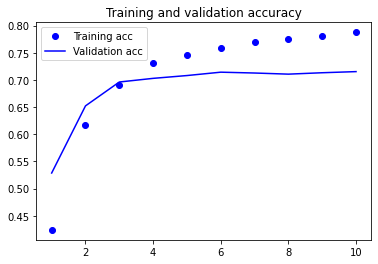

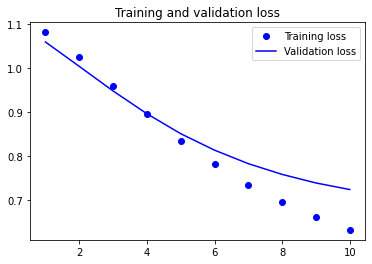

In [93]:
plot_graphs(history)

In [94]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 11s 1ms/step - loss: 0.7104 - acc: 0.7181


[0.7104262113571167, 0.7181395292282104]

In [95]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.76      0.74      0.75      1120
           n       0.57      0.71      0.63       867
         pos       0.83      0.70      0.76      1238

    accuracy                           0.72      3225
   macro avg       0.72      0.72      0.71      3225
weighted avg       0.73      0.72      0.72      3225



In [96]:
# creaza modelul----------------16---------------
base_model = Sequential()
base_model.add(Dense(16, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 16s 37ms/step - loss: 1.0877 - acc: 0.5363 - val_loss: 1.0737 - val_acc: 0.6351
Epoch 2/10
343/343 [==============================] - 12s 37ms/step - loss: 1.0502 - acc: 0.6865 - val_loss: 1.0338 - val_acc: 0.6724
Epoch 3/10
343/343 [==============================] - 12s 34ms/step - loss: 1.0033 - acc: 0.7193 - val_loss: 0.9916 - val_acc: 0.6734
Epoch 4/10
343/343 [==============================] - 12s 34ms/step - loss: 0.9547 - acc: 0.7215 - val_loss: 0.9499 - val_acc: 0.6827
Epoch 5/10
343/343 [==============================] - 12s 35ms/step - loss: 0.9070 - acc: 0.7304 - val_loss: 0.9106 - val_acc: 0.6879
Epoch 6/10
343/343 [==============================] - 12s 35ms/step - loss: 0.8621 - acc: 0.7397 - val_loss: 0.8753 - val_acc: 0.6961
Epoch 7/10
343/343 [==============================] - 12s 35ms/step - loss: 0.8211 - acc: 0.7451 - val_loss: 0.8442 - val_acc: 0.7028
Epoch 8/10
343/343 [==============================] - 12s 35ms

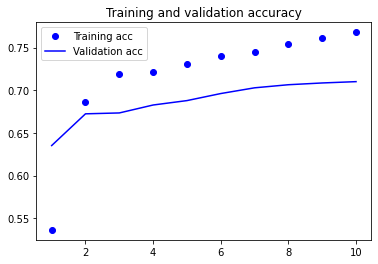

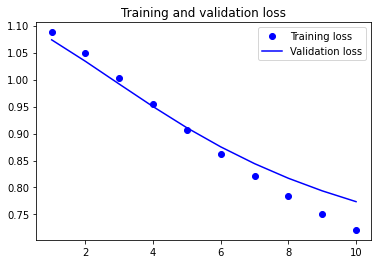

In [97]:
plot_graphs(history)

In [98]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 11s 1ms/step - loss: 0.7628 - acc: 0.7135


[0.7628456354141235, 0.7134883999824524]

In [99]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.79      0.72      0.75      1184
           n       0.52      0.73      0.61       777
         pos       0.84      0.70      0.76      1264

    accuracy                           0.71      3225
   macro avg       0.71      0.72      0.71      3225
weighted avg       0.74      0.71      0.72      3225



In [100]:
# creaza modelul--------------8---------------
base_model = Sequential()
base_model.add(Dense(8, input_shape =(max_features,) , activation = 'relu'))
base_model.add(Dense(3, activation = 'softmax'))

# compile and fit
base_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = base_model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 16s 37ms/step - loss: 1.0947 - acc: 0.4645 - val_loss: 1.0890 - val_acc: 0.5457
Epoch 2/10
343/343 [==============================] - 12s 36ms/step - loss: 1.0781 - acc: 0.6075 - val_loss: 1.0704 - val_acc: 0.6026
Epoch 3/10
343/343 [==============================] - 12s 34ms/step - loss: 1.0546 - acc: 0.6546 - val_loss: 1.0477 - val_acc: 0.6470
Epoch 4/10
343/343 [==============================] - 12s 34ms/step - loss: 1.0270 - acc: 0.6807 - val_loss: 1.0222 - val_acc: 0.6574
Epoch 5/10
343/343 [==============================] - 12s 35ms/step - loss: 0.9966 - acc: 0.6969 - val_loss: 0.9951 - val_acc: 0.6682
Epoch 6/10
343/343 [==============================] - 12s 36ms/step - loss: 0.9647 - acc: 0.7069 - val_loss: 0.9673 - val_acc: 0.6786
Epoch 7/10
343/343 [==============================] - 12s 35ms/step - loss: 0.9325 - acc: 0.7196 - val_loss: 0.9401 - val_acc: 0.6822
Epoch 8/10
343/343 [==============================] - 12s 35ms

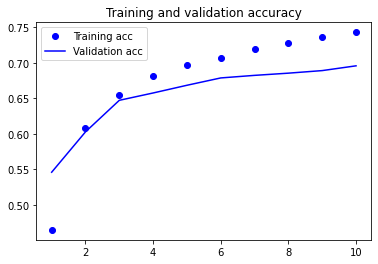

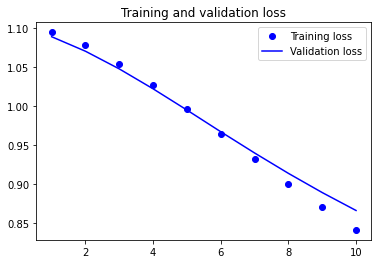

In [101]:
plot_graphs(history)

In [102]:
base_model.evaluate(x_test,y_test)

101/101 [==============================] - 11s 1ms/step - loss: 0.8602 - acc: 0.6967


[0.8601769208908081, 0.6967442035675049]

In [103]:
pred=base_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.79      0.70      0.74      1225
           n       0.43      0.77      0.55       604
         pos       0.87      0.66      0.75      1396

    accuracy                           0.70      3225
   macro avg       0.70      0.71      0.68      3225
weighted avg       0.76      0.70      0.71      3225



In [ ]:
=========================== experimente cu doua straturi + output ========================================

In [37]:
# creaza modelul--------32---8----
model = Sequential()
model.add(Dense(32, input_shape =(max_features,) , activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

# compile and fit
model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = model.fit(x_train,y_train,
                         epochs=10,
                         batch_size=32,
                         validation_split=0.15)

Epoch 1/10
343/343 [==============================] - 1s 2ms/step - loss: 1.0845 - acc: 0.3877 - val_loss: 1.0603 - val_acc: 0.4842
Epoch 2/10
343/343 [==============================] - 1s 2ms/step - loss: 1.0089 - acc: 0.5892 - val_loss: 0.9687 - val_acc: 0.6537
Epoch 3/10
343/343 [==============================] - 1s 1ms/step - loss: 0.8894 - acc: 0.7024 - val_loss: 0.8639 - val_acc: 0.6868
Epoch 4/10
343/343 [==============================] - 1s 2ms/step - loss: 0.7670 - acc: 0.7469 - val_loss: 0.7763 - val_acc: 0.7121
Epoch 5/10
343/343 [==============================] - 1s 2ms/step - loss: 0.6662 - acc: 0.7753 - val_loss: 0.7241 - val_acc: 0.7199
Epoch 6/10
343/343 [==============================] - 1s 2ms/step - loss: 0.5953 - acc: 0.7922 - val_loss: 0.6951 - val_acc: 0.7158
Epoch 7/10
343/343 [==============================] - 1s 2ms/step - loss: 0.5441 - acc: 0.8052 - val_loss: 0.6822 - val_acc: 0.7189
Epoch 8/10
343/343 [==============================] - 1s 3ms/step - loss: 0.

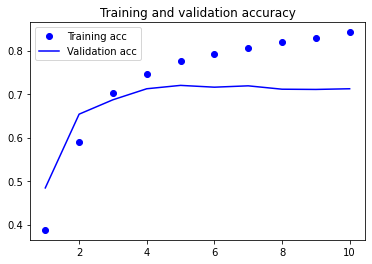

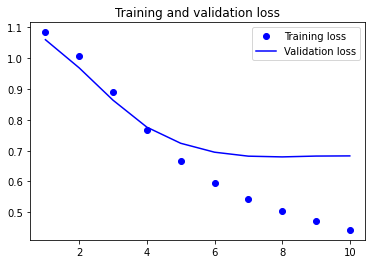

In [38]:
plot_graphs(history)

In [39]:
model.evaluate(x_test,y_test)

101/101 [==============================] - 0s 951us/step - loss: 0.6648 - acc: 0.7157


[0.6648271083831787, 0.7156589031219482]

In [40]:
pred=model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.77      0.74      0.76      1126
           n       0.61      0.66      0.63       986
         pos       0.77      0.73      0.75      1113

    accuracy                           0.72      3225
   macro avg       0.72      0.71      0.71      3225
weighted avg       0.72      0.72      0.72      3225

